In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

# 1. EDA(탐색적 자료 분석)

In [2]:
df=pd.read_csv("data2.csv")
df.head()
# df.info()
# df.isnull().sum()

,date,apt_price,interbank_rate,return_corporate,customer_price,real_estate_tax,amount_current,gdp,exchange_rate
0,2006. 01,62.0,5.02,5.50,79.306,4890,1027697.4,5.6,965
1,2006. 02,62.7,4.87,5.33,79.464,4890,1034711.9,18.7,971
2,2006. 03,63.3,4.93,5.30,79.934,4890,1042293.6,8.6,972
3,2006. 04,63.8,4.95,5.24,80.013,4890,1048598.6,7.8,943
4,2006. 05,64.1,4.78,5.05,80.169,4890,1055855.4,9.8,946


In [3]:
# train set, test set 나누기 50-61
train_set=df[0:168]
test_set=df[168:]
train_set


,date,apt_price,interbank_rate,return_corporate,customer_price,real_estate_tax,amount_current,gdp,exchange_rate
0,2006. 01,62.0,5.02,5.50,79.306,4890,1027697.4,5.6,965
1,2006. 02,62.7,4.87,5.33,79.464,4890,1034711.9,18.7,971
2,2006. 03,63.3,4.93,5.30,79.934,4890,1042293.6,8.6,972
3,2006. 04,63.8,4.95,5.24,80.013,4890,1048598.6,7.8,943
4,2006. 05,64.1,4.78,5.05,80.169,4890,1055855.4,9.8,946
...,...,...,...,...,...,...,...,...,...
163,2019. 08,100.9,1.16,1.69,104.810,3544,2832566.1,-2.4,1211
164,2019. 09,101.3,1.29,1.79,105.200,3544,2853272.0,1.8,1196
165,2019. 10,101.9,1.36,1.86,105.460,3544,2874176.1,-0.8,1163
166,2019. 11,103.0,1.49,2.00,104.870,3544,2901465.4,1.3,1181


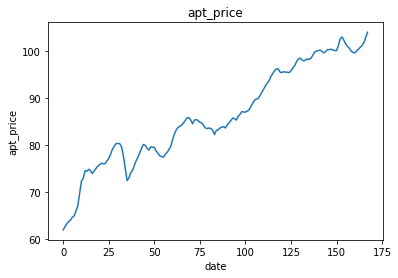

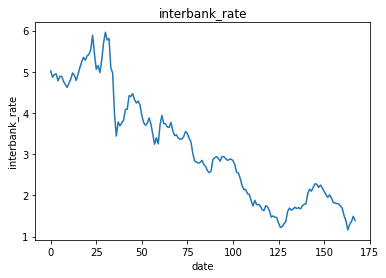

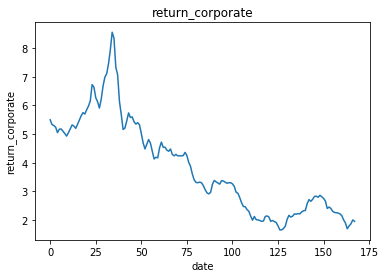

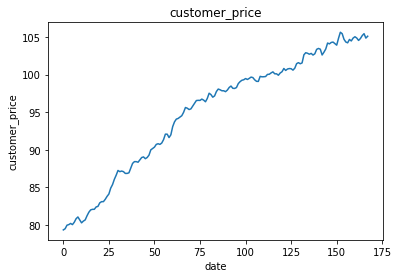

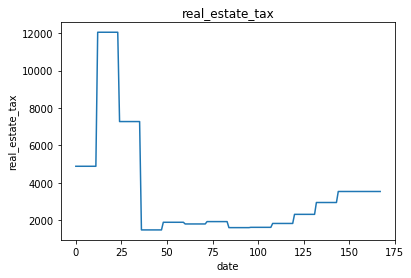

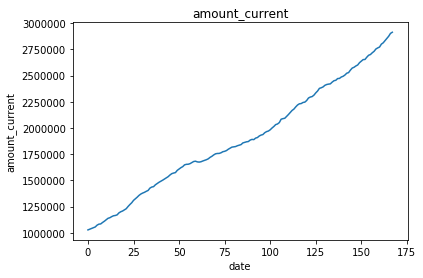

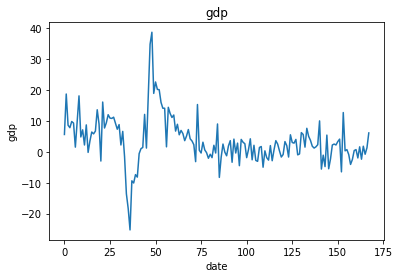

In [4]:
# 아파트 가격 시계열
plt.title("apt_price")
y=train_set["apt_price"]
plt.xlabel("date")
plt.ylabel("apt_price")
plt.plot(y)
plt.show()
# 시장 금리
plt.title("interbank_rate")
y=train_set["interbank_rate"]
plt.xlabel("date")
plt.ylabel("interbank_rate")
plt.plot(y)
plt.show()
# 회사채 수익률
plt.title("return_corporate")
y=train_set["return_corporate"]
plt.xlabel("date")
plt.ylabel("return_corporate")
plt.plot(y)
plt.show()
# 소비자 물가지수
plt.title("customer_price")
y=train_set["customer_price"]
plt.xlabel("date")
plt.ylabel("customer_price")
plt.plot(y)
plt.show()
# 부동산세
plt.title("real_estate_tax")
y=train_set["real_estate_tax"]
plt.xlabel("date")
plt.ylabel("real_estate_tax")
plt.plot(y)
plt.show()
# 통화량
plt.title("amount_current")
y=train_set["amount_current"]
plt.xlabel("date")
plt.ylabel("amount_current")
plt.plot(y)
plt.show()
# gdp
plt.title("gdp")
y=train_set["gdp"]
plt.xlabel("date")
plt.ylabel("gdp")
plt.plot(y)
plt.show()

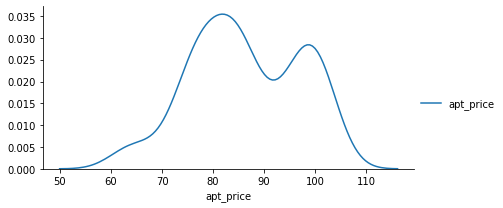

In [5]:
# 아파트 매매 실거래가격지수 밀집도
facet=sns.FacetGrid(train_set,aspect=2)
facet.map(sns.kdeplot,"apt_price")
facet.add_legend()
plt.show()

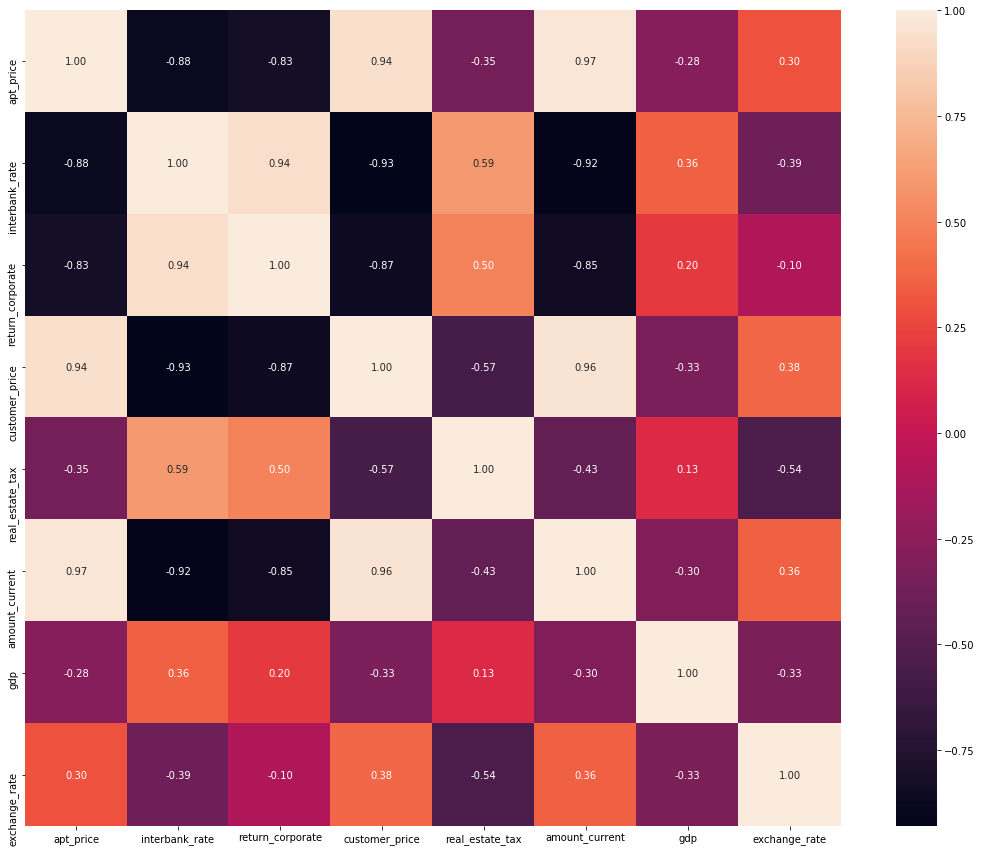

In [6]:
# 변수들간의 상관관계 히트맵으로 관찰하기(다중 공선성 방지)
plt.figure(figsize=(20,15))
sns.heatmap(train_set.corr(),annot=True,fmt=".2f",square=True)
plt.show()

No handles with labels found to put in legend.


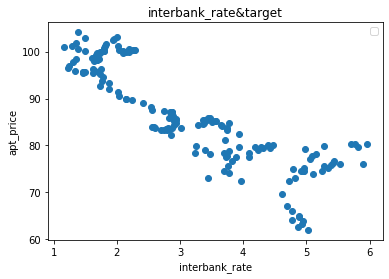

No handles with labels found to put in legend.


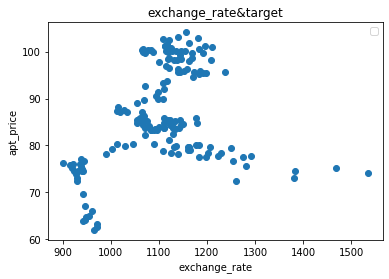

In [7]:
# 실제 각각의 설명변수와 종속변수의 산점도 살펴보기
plt.title("interbank_rate"+"&"+"target")
plt.xlabel("interbank_rate")
plt.ylabel("apt_price")
plt.scatter(train_set["interbank_rate"],train_set["apt_price"])
plt.legend()# legend 
plt.show()

plt.title("exchange_rate"+"&"+"target")
plt.xlabel("exchange_rate")
plt.ylabel("apt_price")
plt.scatter(train_set["exchange_rate"],train_set["apt_price"])
plt.legend()# legend 
plt.show()

# 변수 선택

In [8]:
x_train=train_set[["interbank_rate","return_corporate","customer_price","real_estate_tax","amount_current","gdp","exchange_rate"]]
y_train=train_set["apt_price"]

import statsmodels.api as sm

#forward selection 함수 정의: 입력변수를 하나씩 추가하면서 최소 p-value가 기준값인 cutoff-value보다 큰 변수가 나올 때까지 반복한다.
#함수의 인자로 있는 cutoff 매개변수 값을 조절하면서 학습하면 된다.
def forward_selection(data,target,cutoff=0.15):
    initial_features = data.columns.tolist()
    best_features = []
    while(len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value < cutoff):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features
forwarddata=forward_selection(x_train,y_train,0.5)
print(forwarddata)
def backward_elimination(data, target, cutoff= 0.05):
    features = data.columns.tolist()
    while(len(features) > 0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= cutoff):
            excluded_feature=p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features
backwarddata=backward_elimination(x_train,y_train,0.5)
print(backwarddata)
def stepwise_selection(data,target,cutoff):
    initial_features = data.columns.tolist()
    best_features = []
    while(len(initial_features) > 0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value < cutoff):
            best_features.append(new_pval.idxmin())
            while(len(best_features) > 0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= cutoff):
                    excluded_feature=p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features
stepwisedata=stepwise_selection(x_train,y_train,0.5)
print(stepwisedata)
# 나중에 변수 선택하여 다시 분석할 때
x_train=train_set[["interbank_rate","return_corporate","customer_price","real_estate_tax","amount_current","gdp","exchange_rate"]]
y_train=train_set["apt_price"]
x_test=test_set[["customer_price","real_estate_tax","amount_current","gdp","exchange_rate"]]
y_test=test_set["apt_price"]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


['amount_current', 'real_estate_tax', 'customer_price', 'gdp', 'exchange_rate']
['interbank_rate', 'return_corporate', 'customer_price', 'real_estate_tax', 'amount_current', 'gdp', 'exchange_rate']


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['amount_current', 'real_estate_tax', 'customer_price', 'gdp', 'exchange_rate']


### 데이터 분석: 모델 생성
1) SVM(support vector machine): 

-조절할 수 있는 인자: 
C: 슬랙변수, 오차 허용(boundary 지나치게 가까이에 있는 결과들은 무시, soft margin) 디폴트값은 1이고, 슬랙변수는 오차에 가해진 패널티이므로 c가 증가하면 오차는 줄어들지만 일반화의 오류는 증가.

kernel: 어떤 transformation 함수를 이용하여 고차원으로 사영시킬 것인가? (주로 비선형 boundary를 사용할 때)
kernel의 종류: linear(투영하지 않고), polynomial of power, gaussian(radical-basis funtction)

2) RandomForest Regressor: 
n_estimator(트리의 개수? bootstrap의 개수?):

+앙상블: 
- baggingregressor

4) Ridge regression:

-조절할 수 있는 인자: alpha
alpha(alpha는 회귀계수 앞에 곱해진 패널티. 즉 alpha가 증가할수록 회귀계수 감소)

5) Lasso regreession: sparese 모델, 즉 변수를 선택해주기 때문에 원 데이터 셋으로도 한번 진행해보기


In [9]:
# train set, test set 종속변수, 설명변수 나누기 
# 'interbank_rate', 'return_corporate', 'customer_price', 'real_estate_tax', 'amount_current', 'gdp', 'exchange_rate'
# "customer_price","real_estate_tax","amount_current","gdp","exchange_rate"
x_train=train_set[["interbank_rate","return_corporate","customer_price","real_estate_tax","amount_current","gdp","exchange_rate"]]
y_train=train_set["apt_price"]
x_test=test_set[["interbank_rate","return_corporate","customer_price","real_estate_tax","amount_current","gdp","exchange_rate"]]
y_test=test_set["apt_price"]

poly train set의 mse:  15.677587399414008


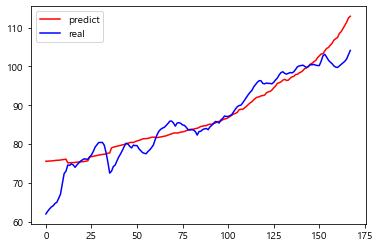

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


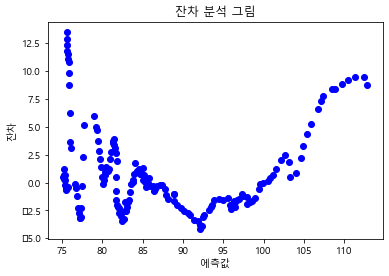

train set의 mse:  2.7455661559683997


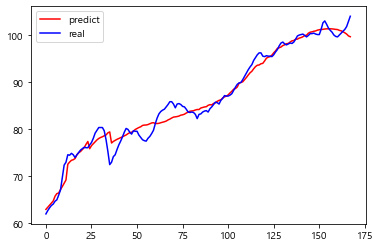

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


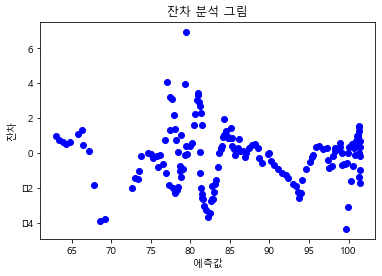

In [10]:
# 비선형 SVR: kernel, C(오차 패널티) 조절 가능: C가 작을수록 일반화 오류는 적어짐
# kernel: rbf로 바꿔보거나 c값 조정하기
from sklearn.svm import SVR
svm1 =SVR(kernel="poly",C=10000)
svm1.fit(x_train, y_train)
svm1.score(x_train, y_train)

y_train_pred=svm1.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse = mean_squared_error(y_train, y_train_pred)
print("poly train set의 mse: ",mse)

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

from sklearn.svm import SVR
svm2 =SVR(kernel="rbf",C=10000)
svm2.fit(x_train, y_train)
svm2.score(x_train, y_train)

y_train_pred=svm2.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse)

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

# 최적의 성능을 보여준 모델을 test set에 적용
y_test_pred=svm1.predict(x_test)
y_test_pred=pd.DataFrame(data=y_test_pred)
y_test=pd.DataFrame(data=y_test,columns=["apt_price"])



In [11]:
y_test_pred

,0
0,113.584211
1,114.653917
2,115.916952
3,117.285267
4,118.628119
5,120.037956


In [12]:
y_test

,apt_price
168,104.9000
169,106.4000
170,107.3000
171,107.3000
172,108.5000
173,111.1908


test set의 mse::  83.05850503453892
test set의 mse::  103.78581441765594


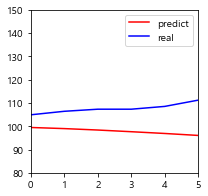

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


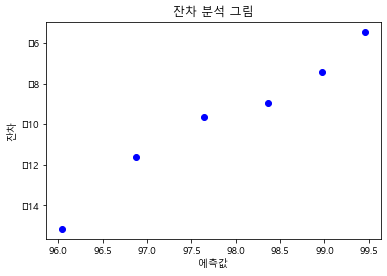

In [13]:
y_test_pred=[113.584211,114.653917,115.916952,117.285267,118.628119,120.037956]
y_test=[104.9000,106.4000,107.3000,107.3000,108.5000,111.1908]
y_test_pred=svm1.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse1)

y_test_pred=svm2.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse2 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse2)

y=y_test_pred
y1=y_test
plt.figure(figsize=(3,3))
plt.ylim((80,150))
plt.xlim((0,5))
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_test_pred,y_test_pred-y_test,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

# 2) Randomforestregressor

train set의 mse:  0.07828651971724843


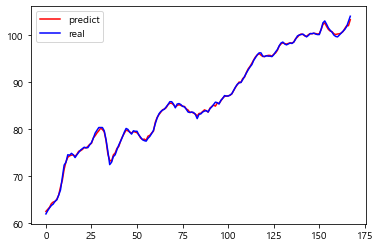

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


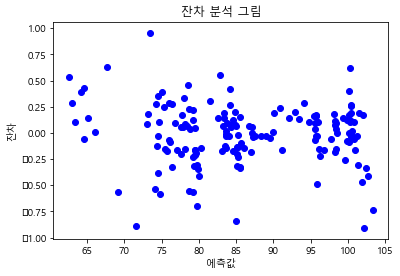

train set의 mse:  0.08138273958335082


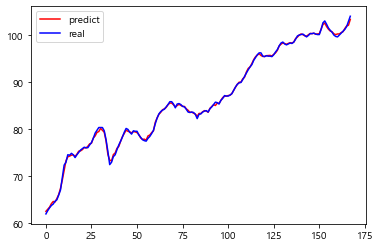

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


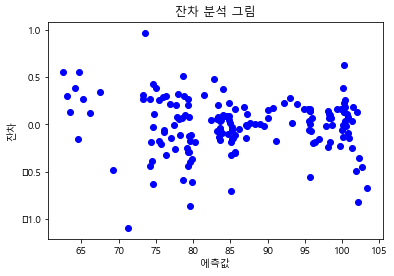

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=400)

rf.fit(x_train, y_train)
rf.score(x_train, y_train)

y_train_pred=rf.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse)


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor(n_estimators=200)

rf1.fit(x_train, y_train)
rf1.score(x_train, y_train)

y_train_pred=rf1.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse1)


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()



test set의 mse::  32.12761618791655
test set의 mse::  31.98212174833307


C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


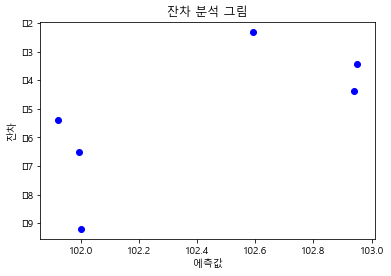

array([102.5925, 102.9505, 102.9405, 101.923 , 101.9955, 102.0015])

In [26]:
y_test_pred=rf.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse1)

y_test_pred=rf1.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse2 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse2)


plt.scatter(y_test_pred,y_test_pred-y_test,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

y_test_pred

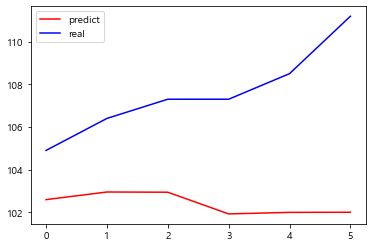

In [25]:
y_test_pred=[102.5925, 102.9505, 102.9405, 101.923 , 101.9955, 102.0015]
y_test=[104.9000,106.4000,107.3000,107.3000,108.5000,111.1908]

plt.plot(y_test_pred,color="red",label="predict")
plt.legend()
plt.plot(y_test,color="blue",label="real")
plt.legend()
plt.show()

# 3) ridge regressor, lasso regressor

coef
[ 7.14616855e-01 -4.80039784e-01  6.87712756e-01  7.36907016e-04
  1.18494825e-05  4.66598127e-02  4.95133265e-03]
intercept
-10.163997562545703
모델 accuracy: 0.9623998246530162
train set의 mse:  4.190142318630143


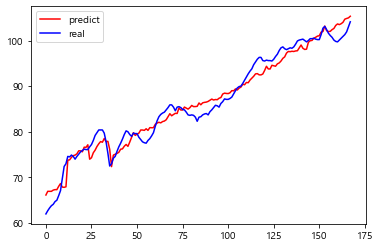

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


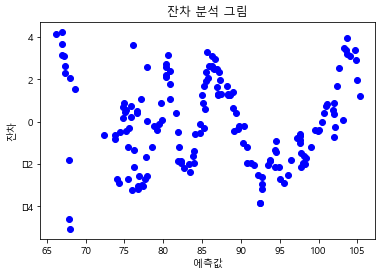

train set의 mse:  4.190142318630143


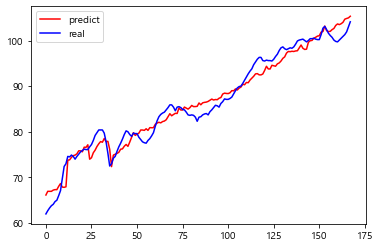

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


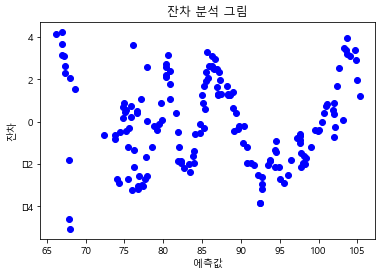

array([105.71746483, 106.76150775, 106.67197836, 105.85316611,
       105.81193682, 106.50712341])

In [19]:
from sklearn.linear_model import Ridge
rid=Ridge(alpha=0.1) #alpha 의미?
rr=rid.fit(x_train,y_train)
print("coef")
print(rr.coef_)
print("intercept")
print(rr.intercept_)
print("모델 accuracy:", rr.score(x_train,y_train))
y_train_pred=rr.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse)


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

from sklearn.linear_model import Ridge
rid=Ridge(alpha=0.1) #alpha 의미?
rr1=rid.fit(x_train,y_train)

rr1.fit(x_train, y_train)
rr1.score(x_train, y_train)

y_train_pred=rr.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse1)


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

# 최적의 성능을 보여준 모델을 test set에 적용
y_test_pred=rr.predict(x_test)
y_test_pred




In [20]:
y_test_pred

array([105.71746483, 106.76150775, 106.67197836, 105.85316611,
       105.81193682, 106.50712341])

test set의 mse::  5.40819768567421
test set의 mse::  5.40819768567421


C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


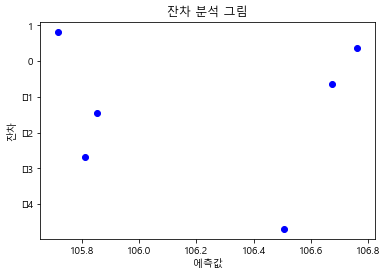

In [27]:
y_test_pred=rr.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse1)

y_test_pred=rr1.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse2 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse2)


plt.scatter(y_test_pred,y_test_pred-y_test,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

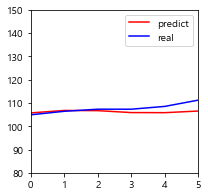

In [28]:
y_test_pred=[105.71746483, 106.76150775, 106.67197836, 105.85316611,
       105.81193682, 106.50712341]
y_test=[104.9000,106.4000,107.3000,107.3000,108.5000,111.1908]
y=y_test_pred
y1=y_test
plt.figure(figsize=(3,3))
plt.ylim((80,150))
plt.xlim((0,5))
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

coef
[ 0.00000000e+00 -0.00000000e+00  6.54548416e-01  7.11288932e-04
  1.20884469e-05  5.24672595e-02  2.36843439e-03]
intercept
-4.144259332310867
모델 accuracy: 0.9621608981981757
train set의 mse:  4.216768147904297


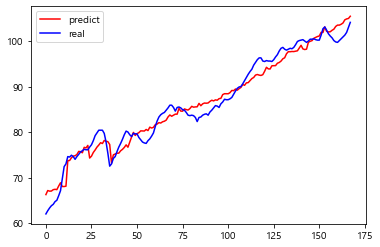

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


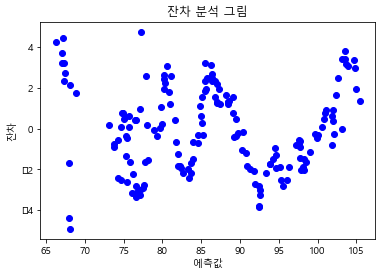

train set의 mse:  4.216768147904297


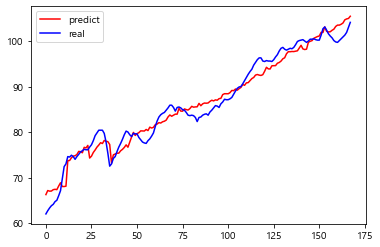

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


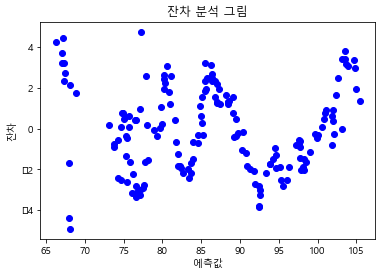

In [31]:
from sklearn.linear_model import Lasso
las=Lasso(alpha=0.1) #alpha 의미?
lr=las.fit(x_train,y_train)
print("coef")
print(lr.coef_)
print("intercept")
print(lr.intercept_)
print("모델 accuracy:", lr.score(x_train,y_train))
y_train_pred=lr.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse)


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

from sklearn.linear_model import Lasso
las=Lasso(alpha=0.5) #alpha 의미?
lr1=las.fit(x_train,y_train)

lr1.fit(x_train, y_train)
lr1.score(x_train, y_train)

y_train_pred=lr.predict(x_train)

from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_train, y_train_pred)
print("train set의 mse: ",mse1)


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'

y=y_train_pred
y1=y_train
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

plt.scatter(y_train_pred,y_train_pred-y_train,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()


test set의 mse::  4.179520600462018
test set의 mse::  2.5416629349039614


C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


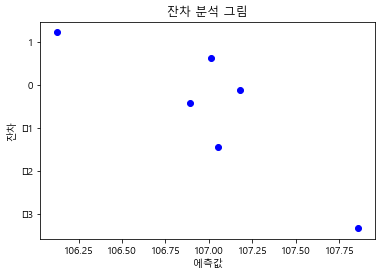

In [29]:
y_test_pred=lr.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse1 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse1)

y_test_pred=lr1.predict(x_test)
from sklearn.metrics import mean_squared_error # 평균제곱오차
mse2 = mean_squared_error(y_test, y_test_pred)
print("test set의 mse:: ",mse2)



plt.scatter(y_test_pred,y_test_pred-y_test,c="blue",marker="o")#train set 예측값 잔차 분석 
plt.xlabel("에측값")
plt.ylabel("잔차")

plt.title("잔차 분석 그림")
plt.show()

In [32]:
y_test_pred

[105.70466308,
 106.81250144,
 106.81957494,
 106.15035796,
 106.15664393,
 107.04162168]

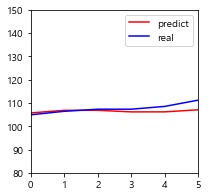

In [30]:
y_test_pred=[105.70466308, 106.81250144, 106.81957494, 106.15035796,
       106.15664393, 107.04162168]
y_test=[104.9000,106.4000,107.3000,107.3000,108.5000,111.1908]
y=y_test_pred
y1=y_test
plt.figure(figsize=(3,3))
plt.ylim((80,150))
plt.xlim((0,5))
plt.plot(y,color="red",label="predict")
plt.legend()
plt.plot(y1,color="blue",label="real")
plt.legend()
plt.show()

# 모델 성능 평가 및 비교